In [1]:
import sys
from crfasrnn_model import get_crfrnn_model_def
from crf_instance_model import get_instance_model
import util
from PIL import Image
import object_detection_class
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import bipartite_loss
import pydensecrf.densecrf as dcrf
import shapePriors
from pydensecrf.utils import compute_unary, create_pairwise_bilateral, \
    create_pairwise_gaussian, softmax_to_unary,unary_from_softmax

Using TensorFlow backend.


In [2]:
def my_to_categorical(y, num_instances):
    #### Create a one-hot encoding for the instance segmentation ground truth ###
    for d in ['/device:GPU:0', '/device:GPU:1', '/device:GPU:2']:
        with tf.device(d):
            one_hot_y = tf.one_hot(indices = y, depth=num_instances+1)
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
   
    Y = sess.run(one_hot_y)
    return Y

In [3]:
def get_color_map_dict():
    ### This function creates a dictionary that maps each class in PASCAL_VOC dataset to a color
    labels = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'void']
    cmap = color_map()
    cmap=list(cmap[0:22])
    cmap=tuple(map(tuple, cmap))
    cmap_dict=dict(zip(cmap,labels))
    cmap_dict[(128,128,64)] = cmap_dict[(128, 64, 128)]
    del cmap_dict[(128, 64, 128)]
    return cmap_dict

In [4]:
def calculate_boxTerm(boxinfo,image,Q,label_map):
    indx = boxinfo['detection_scores'] > 0.45
    scores = boxinfo['detection_scores'][indx]
    num_detections = len(scores)
    classes = boxinfo['detection_classes'][indx]
    boxes = boxinfo['detection_boxes'][indx]
    r,c,_ = image.shape
#     Q = np.stack((probs,probs,probs))
#     Q = Q.swapaxes(0,1).swapaxes(1,2).swapaxes(2,3)
    boxterm = np.zeros(Q.shape)
    
    for i in range(num_detections):

        box = boxes[i]
        ymin,xmin,ymax,xmax = box[0]*r,box[1]*c,box[2]*r,box[3]*c

        xmin = int(round(xmin))
        ymin = int(round(ymin))
        xmax = int(round(xmax))
        ymax = int(round(ymax))
        #We need class info as object detector gives class labels asscociated with coco and semantic segmentation gives wrt PASCAL
        class_info = np.argwhere(label_map == classes[i])
        
        boxterm[ymin:ymax,xmin:xmax,classes[i]] =  Q[ymin:ymax,xmin:xmax,class_info]*scores[i]
        
    return boxterm


In [5]:
def calculate_globalTerm(image,Q):
    img_h,img_w,_ = image.shape
    indx = boxinfo['detection_scores'] > 0.5
    num_detections = len(scores)
    classes = boxinfo['detection_classes'][indx]
#     Q = np.stack((probs,probs,probs))
#     Q = Q.swapaxes(0,1).swapaxes(1,2).swapaxes(2,3)
    shapeTerm = np.zeros(Q.shape)
    
    for i in range(num_detections):
        
        shapeTerm[:img_h, :img_w,classes[i] ]=  Q[:img_h, :img_w,classes[i]]
        
    return shapeTerm

In [6]:
def normalize_probs(probs,image):
    img_h,img_w,_ = image.shape
    Q = np.copy(probs)
    Q_norm = np.zeros(Q.shape)
    for i in range(probs.shape[2]):
        max_Q = np.max(Q[:,:,i])
        Q_norm[:,:,i] = Q[:,:,i]/max_Q
    return Q_norm

In [7]:
def get_label_map():
    labels_pascal = ['background', 'airplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv']
    labels_coco = [obj_detect.category_index[i]['name'] for i in range(1,len(obj_detect.category_index))]
    labels_coco.extend(['background', 'diningtable','motorbike','sofa'])
    label_map = np.zeros(len(labels_pascal))
    for i in range(len(labels_pascal)):
        l = labels_pascal[i]

        ind = labels_coco.index(l)
        label_map[i] = ind+1
    return label_map

In [31]:
def do_instance_segmentation(Q,image,num_detections,boxes,scores,shape_scores,classes,label_map):
    h,w,c = Q.shape
    img_h, img_w, _ = image.shape
    instanceMask = np.zeros((h,w,num_detections))
    s_h, s_w = shape_scores.shape
    pad_h = 500 - s_h
    pad_w = 500 - s_w
    #shape_scores = np.pad(shape_scores, pad_width=((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)
    for i in range(len(boxes)):
        r,c,_ = image.shape
        box = boxes[i]
        s = scores[i]
        #shape_term = shape_scores[i]
#         xmin,ymin,xmax,ymax = box[0]*c,box[1]*r,box[2]*c,box[3]*r

#         xmin = int(round(xmin))
#         ymin = int(round(ymin))
#         xmax = int(round(xmax))
#         ymax = int(round(ymax))
        ymin,xmin,ymax,xmax = box[0]*r,box[1]*c,box[2]*r,box[3]*c

        xmin = int(round(xmin))
        ymin = int(round(ymin))
        xmax = int(round(xmax))
        ymax = int(round(ymax))


    #boxterm[ymin:ymax,xmin:xmax,classes[i]] =  Q[ymin:ymax,xmin:xmax,classes[i]]*scores[i]


        class_info = np.argwhere(label_map == classes[i])
        #Calculate global term
        instanceMask[:,:,i] = np.squeeze(Q[:,:,class_info])*2
        #Calculate box term
        #print((np.squeeze(Q[xmin:xmax,ymin:ymax,class_info])*s).shape)
        
        instanceMask[ymin:ymax,xmin:xmax,i] = (np.squeeze(Q[ymin:ymax,xmin:xmax,class_info])*s)#*shape
        
        shape_scores /= np.max(shape_scores)
        print(np.max(shape_scores))
        #instanceMask[:img_h,:img_w,i] += shape_scores
        
        instanceMask[:,:,i]/=np.max(instanceMask[:,:,i])
    
    instanceMask = instanceMask[:h,:w,:]
    instanceseg = np.zeros((h,w))
    
    for k in range(instanceMask.shape[2]):
        j = instanceMask[:,:,k] > 0.3
        instanceseg[:,:][j] = k+1
    
    instanceseg = np.uint8(instanceseg)
    final_instance_seg = np.zeros((h,w,3))
    
    for x in range(h):
        for y in range(w):
            #For each pixel associate a color for the value at that pixel to get the final instance segmentation
            final_instance_seg[x,y] = np.asarray(colors[instanceseg[x,y]],dtype='uint8')
   
    final_instance_seg = np.uint8(final_instance_seg)
    
    return final_instance_seg


    

In [9]:
def color_map(N=256, normalized=False):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    return cmap

In [10]:
def custom_cross_entropy_loss(y_true, y_pred):
#     labels_gt,mask_gt=bipartite_loss.get_labels_and_masks(y_true,gt_sem)
#     labels_pred,mask_pred=bipartite_loss.get_labels_and_masks(y_pred,final_seg_pred)
#     mbp=bipartite_loss.Maximum_Bipartite_graph(labels_gt,mask_gt,labels_pred,mask_pred)
    return tf.nn.softmax_cross_entropy_with_logits(labels = y_true,logits = y_pred)

In [11]:
colors = [(0, 0, 0),
            (128, 0, 0),
            (0, 128, 0),
            (128, 128, 0),
            (0, 0, 128),
            (128, 0, 128),
            (0, 128, 128),
            (128, 128, 128),
            (64, 0, 0),
            (192, 0, 0),
            (64, 128, 0),
            (192, 128, 0),
            (64, 0, 128),
            (192, 0, 128),
            (64, 128, 128),
            (192, 128, 128),
            (0, 64, 0),
            (128, 64, 0),
            (0, 192, 0),
            (128, 192, 0),
            (0, 64, 128),
            (128, 128, 64)]

In [12]:
_PALETTE = [0, 0, 0,
            128, 0, 0,
            0, 128, 0,
            128, 128, 0,
            0, 0, 128,
            128, 0, 128,
            0, 128, 128,
            128, 128, 128,
            64, 0, 0,
            192, 0, 0,
            64, 128, 0,
            192, 128, 0,
            64, 0, 128,
            192, 0, 128,
            64, 128, 128,
            192, 128, 128,
            0, 64, 0,
            128, 64, 0,
            0, 192, 0,
            128, 192, 0,
            0, 64, 128,
            128, 64, 128,
            0, 192, 128,
            128, 192, 128,
            64, 64, 0,
            192, 64, 0,
            64, 192, 0,
            192, 192, 0]

In [13]:
def get_colors_gt(gt,void_color,bck_col):
    ## This function gives #colors that are present in ground_truth of instance segmentaion. This gives clear idea on #instances
    unique_cols = []
    for x in range(gt.shape[0]):
        for y in range(gt.shape[1]):
            col = list(gt[x,y]*255)
#             print(col)
#             print(void_color)
#             print(unique_cols)
            if ((col not in unique_cols) and not np.all(col==void_color) and not np.all(col==bck_col)):
#                 print('appended')
                unique_cols.append(col)
    return unique_cols



In [14]:
def prepare_data(image_path, gt_ins_path, gt_sem_path):
    #### For the given training data, this function gets the associated semantic segmentation, boxes,scores etc
    seg_probs = []
    boxes_all = []
    detections_all = []
    scores_all = []
    images = []
    for img_file in next(os.path(image_path))[2]:
        image = plt.imread(image_path+"/" + img_file)
        images.append(image)
        gt_sem = plt.imread(gt_sem_path+"/"+img_file.split(".")[0]+".png")
        gt = plt.imread(gt_ins_path+"/"+img_file.split(".")[0]+".png")
        
        Q_detect = np.zeros((Q.shape[0],Q.shape[1],num_detections))

        for i in range(num_detections):
            class_info = np.argwhere(label_map == classes[i])
            Q_detect[:,:,i] = np.squeeze(Q[:,:,class_info])


        h,w,c = Q.shape
        boxTerm = np.zeros((h,w,num_detections))
        globalTerm = np.zeros((h,w,num_detections))
        for i in range(len(boxes)):
            r,c,_ = image.shape
            box = boxes[i]
            s = scores[i]
            ymin,xmin,ymax,xmax = box[0]*r,box[1]*c,box[2]*r,box[3]*c

            xmin = int(round(xmin))
            ymin = int(round(ymin))
            xmax = int(round(xmax))
            ymax = int(round(ymax))




            class_info = np.argwhere(label_map == classes[i])
            globalTerm[:,:,i] = np.squeeze(Q[:,:,class_info])
            
            boxTerm[ymin:ymax,xmin:xmax,i] = np.squeeze(Q[ymin:ymax,xmin:xmax,class_info])*s
            boxTerm[:,:,i]/=np.max(boxTerm[:,:,i])

        
        uniq_cols = get_colors_gt(gt,np.array([224, 224, 192]),np.array([0, 0, 0]))
    #     gt  = plt.imread('gt_2007_000925.png')
    #     gt_sem = plt.imread('gt_2007_000925_sem.png')
        h,w,_ = gt.shape
        pad_h = 500 - h
        pad_w = 500 - w
        gt = np.pad(gt, pad_width=((0, pad_h), (0, pad_w), (0, 0)), mode='constant', constant_values=0)
        instance_map = np.zeros((gt.shape[0],gt.shape[1]))
        for x in range(gt.shape[0]):
            for y in range(gt.shape[1]):
                col = list(gt[x,y]*255)
                if(col in uniq_cols):
                    i = uniq_cols.index(col)
                    instance_map[x,y] = i+1
                else:
                    instance_map[x,y] = 0

        Q_detect_exp = np.expand_dims(Q_detect,axis=0)
        boxTerm = np.expand_dims(boxTerm,axis = 0)
        globalTerm = np.expand_dims(globalTerm,axis = 0)
        
        seg_probs.append(Q_detect_exp)
        boxes_all.append(boxes)
        scores_all.append(scores)
        detections_all.append(num_detections)
    
    
    gt_categorical  = my_to_categorical(instance_map,np.max(instance_map))

    gt_categorical_exp = np.expand_dims(gt_categorical[:,:,1:],axis = 0)

    return images, seg_probs, boxes_all,scores_all,detections_all

    

In [15]:
############ Training ################
# earlystopper = EarlyStopping(patience=5, verbose=1)
# checkpointer = ModelCheckpoint('instance_seg_model.h5', verbose=1, save_best_only=True)
# results = model.fit(x = [Q_detect_exp, boxTerm, globalTerm],y = gt_categorical_exp,,epochs=30, validation_split=0.1, batch_size=1,callbacks=[earlystopper, checkpointer])


In [16]:
semantic_model = get_crfrnn_model_def()

saved_model_path = 'crfrnn_keras_model.h5'

semantic_model.load_weights(saved_model_path)

obj_detect = object_detection_class.object_detection()

[(None, 500, 500, 21), (None, 500, 500, 3)]


/home/prathyuakundi/miniconda3/envs/tfenv/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  import sys


In [17]:
def pixelwise_instance_segmentation(input_file, obj_detect,semantic_model):
    image = plt.imread(input_file)
    

    boxinfo = obj_detect.detect_box(image)

    indx = np.floor(boxinfo['detection_scores']*100) > 50 

    scores = boxinfo['detection_scores'][indx]

    num_detections = len(scores)

    classes = boxinfo['detection_classes'][indx]
    boxes = boxinfo['detection_boxes'][indx]
    
    boxinfo['detection_boxes']  = boxes
    
    boxinfo['detection_classes'] = classes
    
    boxinfo['detection_scores'] = scores
    
    boxinfo_wimage = {}
    
    boxinfo_wimage[input_file] = boxinfo
    r,c,_ = image.shape

    img2  = np.copy(image)
    
    instance_model = get_instance_model(num_detections)
    
    img_data, img_h, img_w = util.get_preprocessed_image(image)

    probs = semantic_model.predict(img_data, verbose=True)[0, :, :, :]
    
    saved_model_path = 'instance_seg_model.h5'
    
    Q = normalize_probs(probs,image)
    
    label_map = get_label_map()
    
    scores = scores*100
    shape_temp_file = "shapeTemplates.mat"
    # TODO Change folder name
    train_loc = "test_images"
    bb_img_name, bb_cls, bb_coord, bb_score = shapePriors.bbox_data(boxinfo_wimage)
    
    # Getting shape templates
    shape_templates = shapePriors.get_shape_templates(shape_temp_file)
    train_img_dict = shapePriors.create_img_dict(train_loc)

    # Generating shape term for each box
    bb_shape_terms = shapePriors.gen_shape_terms(bb_coord, image, shape_templates)
    print(bb_shape_terms.shape)
    
    
    
    final_instance_seg = do_instance_segmentation(Q,image,num_detections,boxes,scores,bb_shape_terms,classes,label_map)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.imshow(final_instance_seg[:image.shape[0], :image.shape[1]],alpha = 0.5)

    plt.xticks([])
    plt.yticks([])
    
    return probs, boxes


    

In [53]:
input_file = 'test_images/2007_002967.jpg'


1/1 [==============================] - 9s 9s/step
(500, 336)
1.0
1.0


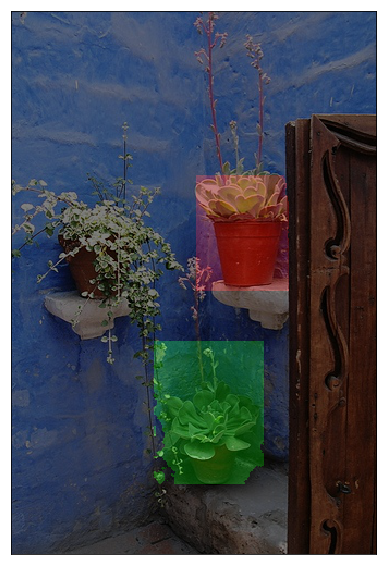

In [54]:
Q, boxes = pixelwise_instance_segmentation(input_file, obj_detect,semantic_model)

In [55]:
Q.shape

(500, 500, 21)

([], <a list of 0 Text yticklabel objects>)

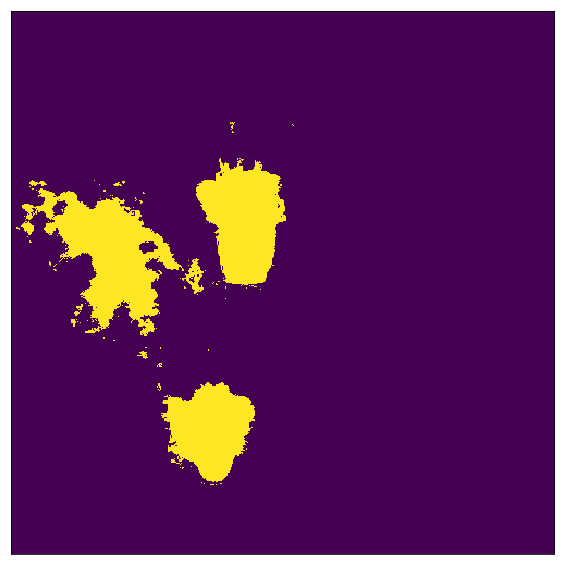

In [56]:
plt.figure(figsize=(10,10))
plt.imshow(Q.argmax(axis=2))
plt.xticks([])
plt.yticks([])

In [57]:
image = plt.imread(input_file)
r,c,_ = image.shape

for i in range(len(boxes)):
    box = boxes[i]
    
    xmin,ymin,xmax,ymax = box[0]*r,box[1]*c,box[2]*r,box[3]*c

    xmin = int(round(xmin))
    ymin = int(round(ymin))
    xmax = int(round(xmax))
    ymax = int(round(ymax))
    
    image = cv2.rectangle(image, (ymin,xmin),(ymax,xmax),color = (128,128,200),thickness=5)

    

In [58]:
np.max(image)

255

([], <a list of 0 Text yticklabel objects>)

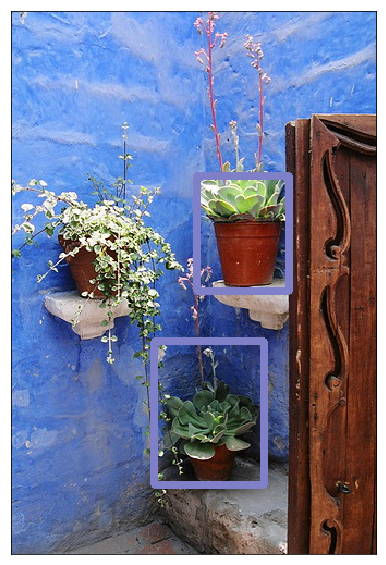

In [59]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.xticks([])
plt.yticks([])